# Teeth prediction

# Outline
<div class="alert alert-block alert-danger" >

- [ 1 - import libararies & read the data ](#1)
- [ 2 - Visualization](#2)
- [3 - Data Augmentation](#3)
- [4 - Model & Training](#4)

<div class="alert alert-block alert-info" >
<a name='1'></a>
    <h1> 1 - import libararies & read the data </h1>
</div>

In [1]:
import tensorflow as tf

from tensorflow import keras
import os 
import zipfile
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight

In [2]:
# Set random seeds
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [3]:
tf.test.is_built_with_cuda()

True

In [4]:
len(tf.config.experimental.list_physical_devices('GPU'))

1

In [5]:
main_dir = 'Teeth_Dataset'

train_dir = os.path.join(main_dir, 'Training')
test_dir = os.path.join(main_dir, 'Testing')
val_dir = os.path.join(main_dir, 'Validation')

In [6]:
train_CaS_dir = os.path.join(train_dir, 'CaS')
train_CoS_dir = os.path.join(train_dir, 'CoS')
train_Gum_dir = os.path.join(train_dir, 'Gum')
train_MC_dir = os.path.join(train_dir, 'MC')
train_OC_dir = os.path.join(train_dir, 'OC')
train_OLP_dir = os.path.join(train_dir, 'OLP')
train_OT_dir = os.path.join(train_dir, 'OT')

test_CaS_dir = os.path.join(test_dir, 'CaS')
test_CoS_dir = os.path.join(test_dir, 'CoS')
test_Gum_dir = os.path.join(test_dir, 'Gum')
test_MC_dir = os.path.join(test_dir, 'MC')
test_OC_dir = os.path.join(test_dir, 'OC')
test_OLP_dir = os.path.join(test_dir, 'OLP')
test_OT_dir = os.path.join(test_dir, 'OT')

val_CaS_dir = os.path.join(val_dir, 'CaS')
val_CoS_dir = os.path.join(val_dir, 'CoS')
val_Gum_dir = os.path.join(val_dir, 'Gum')
val_MC_dir = os.path.join(val_dir, 'MC')
val_OC_dir = os.path.join(val_dir, 'OC')
val_OLP_dir = os.path.join(val_dir, 'OLP')
val_OT_dir = os.path.join(val_dir, 'OT')

In [7]:
os.listdir(train_CaS_dir)[:10]

['a_100_0_1462.jpg',
 'a_100_0_4424.jpg',
 'a_100_0_5215.jpg',
 'a_100_0_5539.jpg',
 'a_100_0_6127.jpg',
 'a_100_0_6639.jpg',
 'a_101.jpg',
 'a_101_0_1029.jpg',
 'a_101_0_1757.jpg',
 'a_101_0_5683.jpg']

<div class="alert alert-block alert-info" >
<a name='2'></a>
    <h1> 2 - Visualization </h1>
</div>

In [8]:
for dir, dirname, filename in os.walk(main_dir):
  print(f"Found {len(dirname)} directories and {len(filename)} images in {dir}")

Found 3 directories and 0 images in Teeth_Dataset
Found 7 directories and 0 images in Teeth_Dataset\Testing
Found 0 directories and 160 images in Teeth_Dataset\Testing\CaS
Found 0 directories and 149 images in Teeth_Dataset\Testing\CoS
Found 0 directories and 120 images in Teeth_Dataset\Testing\Gum
Found 0 directories and 180 images in Teeth_Dataset\Testing\MC
Found 0 directories and 108 images in Teeth_Dataset\Testing\OC
Found 0 directories and 180 images in Teeth_Dataset\Testing\OLP
Found 0 directories and 131 images in Teeth_Dataset\Testing\OT
Found 7 directories and 0 images in Teeth_Dataset\Training
Found 0 directories and 480 images in Teeth_Dataset\Training\CaS
Found 0 directories and 450 images in Teeth_Dataset\Training\CoS
Found 0 directories and 360 images in Teeth_Dataset\Training\Gum
Found 0 directories and 540 images in Teeth_Dataset\Training\MC
Found 0 directories and 324 images in Teeth_Dataset\Training\OC
Found 0 directories and 540 images in Teeth_Dataset\Training\OLP


In [9]:
data_for_viz = tf.keras.preprocessing.image_dataset_from_directory(
    
          train_dir,
          image_size=(180,180))

Found 3087 files belonging to 7 classes.


In [10]:
def image_viz(dataset):
  
  plt.figure(figsize=(12, 8))
  
  index = 0
  for image, label in dataset.take(12):
    
    index +=1
    ax = plt.subplot(4, 4, index)
    plt.imshow(image[index].numpy().astype("uint8"))
    plt.title(int(label[index]))
    plt.axis("off")

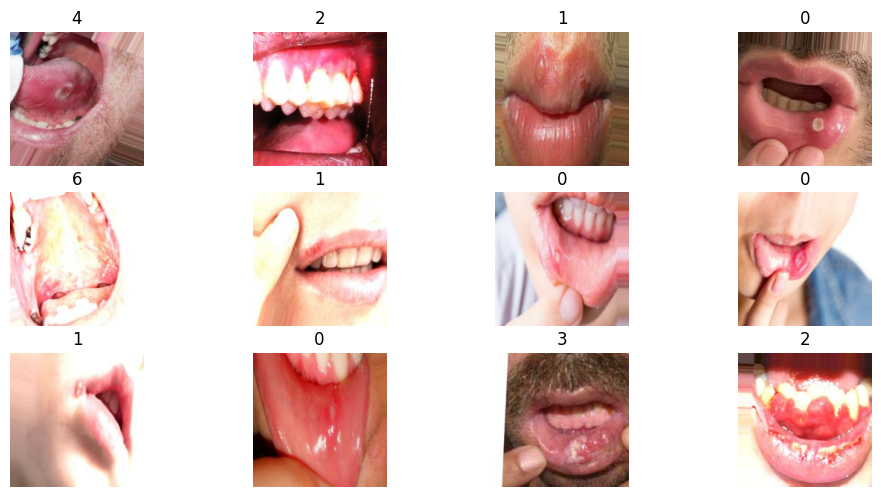

In [11]:
image_viz(data_for_viz)

In [12]:
# function to plot accuracy and loss

def plot_acc_loss(acc, val_acc, loss, val_loss, epochs):

    plt.figure(figsize=(10,5))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'g', label='Validation Accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    
    plt.ylabel('Accuracy')
    plt.legend(loc=0)
               
    # Create a new figure with plt.figure()
    plt.figure()
    plt.figure(figsize=(10,5))
    plt.plot(epochs, loss, 'b', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend(loc=0)
    plt.show()

<div class="alert alert-block alert-info" >
<a name='3'></a>
    <h1> 3 - Data Augmentation </h1>
</div>

In [13]:
class_names = ['CaS', 'CoS', 'Gum','MC','OC','OLP','OT']

In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_imagenerator = ImageDataGenerator(
    
    rescale=1/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range= 0.2,
    horizontal_flip=True,
    fill_mode='nearest'
    
)


In [15]:
val_imagenerator = ImageDataGenerator(rescale=1/255.)

In [16]:
# Load training images in batches of 20 while applying aumgmentation

batch_size = 20
target_size = (224,224)
input_shape = (224,224,3)

train_generator = train_imagenerator.flow_from_directory(
        train_dir, #parent directory must be specified
        target_size = target_size, # All images will be resized to (180,180)
        batch_size=batch_size,
        class_mode='categorical' # since we need binary labels(0,1) and we will use binary_crossentropy

) 

Found 3087 images belonging to 7 classes.


In [17]:
val_generator = val_imagenerator.flow_from_directory(
        val_dir, #parent directory must be specified
        target_size = target_size, # All images will be resized to (180,180)
        batch_size=batch_size,
        class_mode='categorical' # since we need binary labels(0,1) and we will use binary_crossentropy

) 

Found 1028 images belonging to 7 classes.


In [18]:
print(train_generator.samples)
print(val_generator.samples)

3087
1028


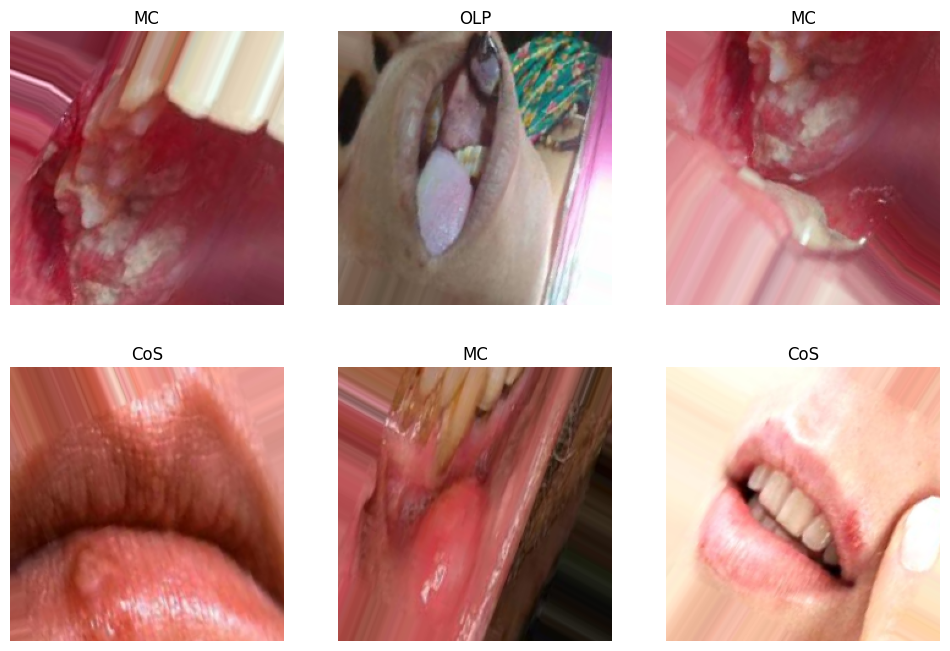

In [19]:
# Get images in batch of 20
augmented_image, label = train_generator.next()

plt.figure(figsize=(12,8))
for i in range(6):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(augmented_image[i])
        plt.title(class_names[np.argmax(label[i])])
        plt.axis("off")

<div class="alert alert-block alert-info" >
<a name='4'></a>
    <h1> 4 - Model & Training </h1>
</div>

In [20]:
def classifier(num_classes):

    model = tf.keras.models.Sequential([

        # First convolution and pooling layer
        tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(180, 180, 3)),
        tf.keras.layers.BatchNormalization(),  # Batch Normalization
        tf.keras.layers.MaxPooling2D(2, 2),
        tf.keras.layers.Dropout(0.1),  # Dropout

        # Second convolution and pooling layer
        tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Batch Normalization
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.1),  # Dropout

        # Third convolution and pooling layer
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Batch Normalization
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.1),  # Dropout
        
        # Fourth convolution and pooling layer
        tf.keras.layers.Conv2D(256, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Batch Normalization
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.1),  # Dropout
        
        # Fifth convolution and pooling layer
        tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
        tf.keras.layers.BatchNormalization(),  # Batch Normalization
        tf.keras.layers.MaxPooling2D(2,2),
        tf.keras.layers.Dropout(0.1),  # Dropout

        # Flattening layer
        tf.keras.layers.Flatten(),

        # Fully connected layers
        tf.keras.layers.Dense(128, activation='relu'),
#         tf.keras.layers.BatchNormalization(),  # Batch Normalization
#         tf.keras.layers.Dropout(0.5),  # Dropout
        tf.keras.layers.Dense(64, activation='relu'),
#         tf.keras.layers.BatchNormalization(),  # Batch Normalization
#         tf.keras.layers.Dropout(0.5),  # Dropout
#         tf.keras.layers.Dense(32, activation='relu'),
#         tf.keras.layers.BatchNormalization(),  # Batch Normalization
#         tf.keras.layers.Dropout(0.5),  # Dropout

        # Output layer for multi-class classification
        tf.keras.layers.Dense(num_classes, activation='softmax')
    ])

    # Compiling the model with a suitable loss function for multi-class classification
    model.compile(
        optimizer=tf.keras.optimizers.Adam(),
        loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
        metrics=['accuracy']
    )
    
    return model

In [24]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, SpatialDropout2D
from tensorflow.keras.regularizers import l2
from tensorflow.keras.applications import MobileNet

def classifier(num_classes, input_shape):
    # Load the MobileNet model with pretrained weights, excluding the top layer (fully connected layers)
    base_model = MobileNet(weights='imagenet', include_top=False, input_shape=input_shape)

    # Create a Sequential model
    model = Sequential()

    # Add the MobileNet base model
    model.add(base_model)

    # Add Spatial Dropout to the convolutional layers
    model.add(SpatialDropout2D(0.25))  # 25% spatial dropout rate

    # Add a Flatten layer
    model.add(Flatten())

    # Add custom fully connected layers with BatchNormalization, Dropout, and kernel regularization
    model.add(Dense(256, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.1))

    # Output layer
    model.add(Dense(num_classes, activation='softmax'))

    # Freeze the base model layers
    for layer in base_model.layers:
        layer.trainable = False

    # Compile the model with a suitable loss function for multi-class classification
    model.compile(
        optimizer=tf.keras.optimizers.RMSprop(),
        loss='categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
        metrics=['accuracy']
    )

    return model


In [25]:
model = classifier(7,input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet_1.00_224 (Functio  (None, 7, 7, 1024)       3228864   
 nal)                                                            
                                                                 
 spatial_dropout2d (SpatialD  (None, 7, 7, 1024)       0         
 ropout2D)                                                       
                                                                 
 flatten (Flatten)           (None, 50176)             0         
                                                                 
 dense (Dense)               (None, 256)               12845312  
                                                                 
 batch_normalization (BatchN  (None, 256)              1024      
 ormalization)                                                   
                                                        

In [26]:
# Get class labels and counts
class_indices = train_generator.class_indices
num_classes = len(class_indices)
class_counts = np.bincount(train_generator.classes)

# Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.arange(num_classes),
    y=train_generator.classes
)

# Convert to dictionary format for the model
class_weight_dict = dict(enumerate(class_weights))

print("Class Weights:", class_weight_dict)

Class Weights: {0: 0.91875, 1: 0.98, 2: 1.225, 3: 0.8166666666666667, 4: 1.3611111111111112, 5: 0.8166666666666667, 6: 1.1221374045801527}


In [27]:
# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',   # Metric to monitor
    patience=5,           # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored metric
)

In [28]:
# ReduceLROnPlateau: Reduce the learning rate when the metric has stopped improving.
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',   # Metric to monitor
    factor=0.5,           # Factor by which the learning rate will be reduced
    patience=3,           # Number of epochs with no improvement to wait before reducing the learning rate
    min_lr=1e-6           # Lower bound on the learning rate
)

In [29]:
# ModelCheckpoint: Save the model after every epoch.
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'best_model.h5',       # Filepath to save the model
    monitor='val_loss',     # Metric to monitor
    save_best_only=True,    # Only save the best model
    save_weights_only=True  # Only save the model's weights
)

In [30]:
model = classifier(7, input_shape)

batch_size = 20

train_steps = 2000/batch_size
val_steps = 1000/batch_size

history = model.fit(
      train_generator,
      steps_per_epoch=train_steps,  
      epochs = 1000,
      class_weight=class_weight_dict,
      validation_data=val_generator,
      validation_steps=val_steps,
      callbacks=[early_stopping,reduce_lr_on_plateau,checkpoint])

Epoch 1/1000
100/100 [==============================] - 21s 164ms/step - loss: 7.9484 - accuracy: 0.4670 - val_loss: 7.4249 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 2/1000
100/100 [==============================] - 18s 179ms/step - loss: 6.0861 - accuracy: 0.5732 - val_loss: 5.5383 - val_accuracy: 0.6460 - lr: 0.0010
Epoch 3/1000
100/100 [==============================] - 17s 174ms/step - loss: 5.2397 - accuracy: 0.6165 - val_loss: 4.9244 - val_accuracy: 0.6860 - lr: 0.0010
Epoch 4/1000
100/100 [==============================] - 18s 179ms/step - loss: 4.8863 - accuracy: 0.6080 - val_loss: 4.3453 - val_accuracy: 0.7000 - lr: 0.0010
Epoch 5/1000
100/100 [==============================] - 18s 178ms/step - loss: 4.4644 - accuracy: 0.6044 - val_loss: 4.0308 - val_accuracy: 0.7460 - lr: 0.0010
Epoch 6/1000
100/100 [==============================] - 18s 179ms/step - loss: 4.2189 - accuracy: 0.6120 - val_loss: 3.8578 - val_accuracy: 0.7050 - lr: 0.0010
Epoch 7/1000
100/100 [==================

Epoch 101/1000
100/100 [==============================] - 18s 177ms/step - loss: 0.5710 - accuracy: 0.8863 - val_loss: 0.3028 - val_accuracy: 0.9880 - lr: 3.1250e-05
Epoch 102/1000
100/100 [==============================] - 18s 177ms/step - loss: 0.5502 - accuracy: 0.9004 - val_loss: 0.2927 - val_accuracy: 0.9900 - lr: 3.1250e-05
Epoch 103/1000
100/100 [==============================] - 18s 178ms/step - loss: 0.5185 - accuracy: 0.9104 - val_loss: 0.2887 - val_accuracy: 0.9920 - lr: 3.1250e-05
Epoch 104/1000
100/100 [==============================] - 18s 176ms/step - loss: 0.5339 - accuracy: 0.9040 - val_loss: 0.2872 - val_accuracy: 0.9900 - lr: 3.1250e-05
Epoch 105/1000
100/100 [==============================] - 18s 180ms/step - loss: 0.5022 - accuracy: 0.9120 - val_loss: 0.2833 - val_accuracy: 0.9920 - lr: 3.1250e-05
Epoch 106/1000
100/100 [==============================] - 18s 183ms/step - loss: 0.5061 - accuracy: 0.9045 - val_loss: 0.2831 - val_accuracy: 0.9900 - lr: 3.1250e-05
Epoc

In [31]:
model_history = history.history

acc = model_history['accuracy']
val_acc = model_history['val_accuracy']
loss = model_history['loss']
val_loss = model_history['val_loss']

epochs = history.epoch

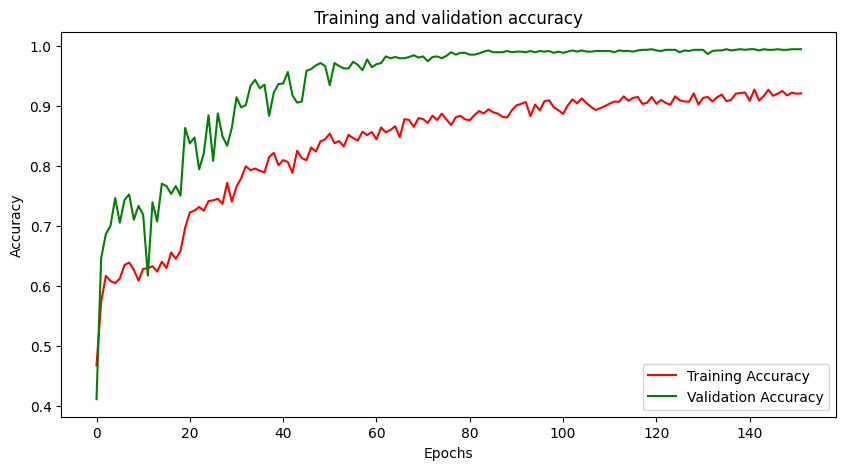

<Figure size 640x480 with 0 Axes>

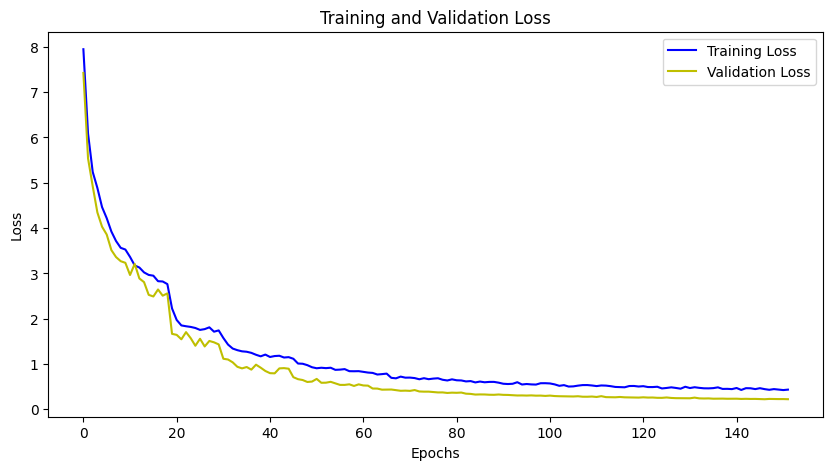

In [32]:
plot_acc_loss(acc, val_acc, loss, val_loss, epochs)

In [38]:
model_file_name = f'mobilenet_1.00_224_0.h5'

# Save the Model
model.save(model_file_name)

In [39]:
model = load_model('mobilenet_1.00_224_0.h5')

In [40]:
test_imagenerator = ImageDataGenerator(rescale=1/255.)

In [41]:
test_imagenerator = test_imagenerator.flow_from_directory(
        test_dir, #parent directory must be specified
        target_size = target_size, # All images will be resized to (180,180)
        batch_size=batch_size,
        class_mode='categorical' # since we need binary labels(0,1) and we will use binary_crossentropy

) 

Found 1028 images belonging to 7 classes.


In [42]:
# Evaluate the model on the test data
loss, accuracy = model.evaluate(test_imagenerator)

print(f'Test Loss: {loss}')
print(f'Test Accuracy: {accuracy}')

52/52 [==============================] - 2s 33ms/step - loss: 0.2254 - accuracy: 0.9951
Test Loss: 0.22537469863891602
Test Accuracy: 0.9951362013816833
